# 7. KMeans Clustering with Scikit-Learn and MLlib

Implement the K-Means Algorithm using Scikit-Learn and MLlib!

In [1]:
%matplotlib inline
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets

The dataset class provides access to different public datasets. It will return a scikit-learn bunch: <http://scikit-learn.org/stable/datasets/index.html>

In [2]:
iris = datasets.load_iris()

Convert Scikit Bunch to Pandas Dataframe

In [3]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df["target_name"]=iris['target_names'][iris_df['target']] 
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


## 7.1 Cluster the data using the KMeans implementation of scikit-learn!

* Resource: <http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html>
* Measure the runtime for training the model!
* Experiment with different number of clusters! What are your observations!
* Plot the results!

In [4]:
iris_df.shape

(150, 6)

**Data normalization:**

In [5]:
iris_df.iloc[:,:4] = (iris_df.iloc[:,:4] - iris_df.iloc[:,:4].mean())/iris_df.iloc[:,:4].std()

In [6]:
X = iris_df.iloc [:, :4].values
y = iris_df.target.values

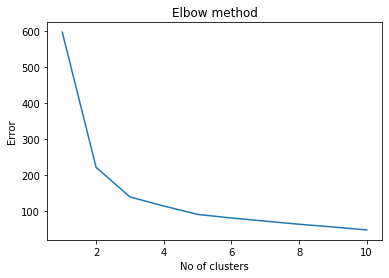

In [7]:
errors =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(X)
    kmeans.fit(X)
    errors.append(kmeans.inertia_)

plt.plot(range(1, 11), errors)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [8]:
kmeans = KMeans(n_clusters=3, random_state=0)

In [9]:
%%time 
kmeans.fit(iris_df.iloc[:,:4])

CPU times: user 38.3 ms, sys: 0 ns, total: 38.3 ms
Wall time: 37.2 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [10]:
y_kMeans = kmeans.predict(iris_df.iloc[:,:4])

**Predicted labels:**

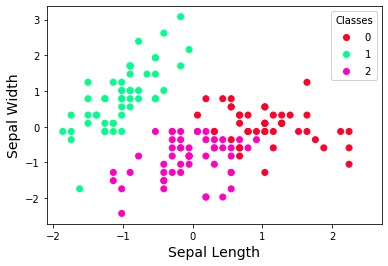

In [11]:
fig, ax = plt.subplots()
scatter = ax.scatter(X[:,0], X[:,1], c=y_kMeans, cmap='gist_rainbow')
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)
plt.xlabel('Sepal Length', fontsize=14)
plt.ylabel('Sepal Width', fontsize=14)
plt.show()

In [12]:
remapping_classes_to_corresponding_classes = {0:1, 1:2, 2:0}

In [13]:
remapped_iris_df = iris_df.copy()
remapped_iris_df.target = remapped_iris_df.target.map(remapping_classes_to_corresponding_classes)

**True labels:**

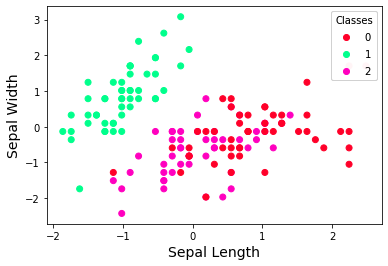

In [14]:
fig, ax = plt.subplots()
scatter = ax.scatter(remapped_iris_df.iloc[:,0], remapped_iris_df.iloc[:,1], c=remapped_iris_df.target, cmap='gist_rainbow')
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)
plt.xlabel('Sepal Length', fontsize=14)
plt.ylabel('Sepal Width', fontsize=14)
plt.show()

## 7.2 MLlib Clustering

* MLLib KMeans Example: 
    * <https://spark.apache.org/docs/latest/ml-clustering.html>
    * <https://spark.apache.org/docs/latest/api/python/>
    * <https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.ClusteringEvaluator>
* Run KMeans on the provided Iris dataset!
* Validate the quality of the model using the sum of the squared error for each point! Use the ClusterEvaluator of Spark MLlib!

In [15]:
# Initialize PySpark
import os, sys
APP_NAME = "PySpark Lecture"
SPARK_MASTER="local[1]"
import pyspark
import pyspark.sql
from pyspark.sql import Row
from pyspark.ml.feature import VectorAssembler
conf=pyspark.SparkConf()
conf=pyspark.SparkConf().setAppName(APP_NAME).set("spark.local.dir", os.path.join(os.getcwd(), "tmp"))
sc = pyspark.SparkContext(master=SPARK_MASTER, conf=conf)
spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initiated...")

PySpark initiated...


In [32]:
spark_iris_df = spark.createDataFrame(iris_df)
spark_iris_df = spark_iris_df.withColumnRenamed("target","label")
vecAssembler = VectorAssembler(inputCols = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], outputCol = 'features')
vectorised_spark_iris_df = vecAssembler.transform(spark_iris_df)
vectorised_spark_iris_df = vectorised_spark_iris_df.select(['features', 'label'])

In [17]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [18]:
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(vectorised_spark_iris_df)

In [19]:
predictions = model.transform(vectorised_spark_iris_df)

In [20]:
evaluator = ClusteringEvaluator()

In [21]:
silhouette = evaluator.evaluate(predictions)

In [22]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-0.07697634 -0.92751406  0.32205924  0.23648596]
[-1.01119138  0.85041372 -1.30063009 -1.25070352]
[1.06532176 0.05740203 0.96569807 0.99896792]


#### Model Evaluation

* https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.ClusteringEvaluator

* Evaluator for Clustering results, which expects two input columns: prediction and features. The metric computes the Silhouette measure using the squared Euclidean distance.

## 7.3 Manual KMeans Clustering

Implement a KMeans Model using Spark MapReduce (Do Not use MLlib version!)!

In [68]:
NUMBER_OF_CLUSTERS = 3
vectorised_spark_iris_df_rdd = vectorised_spark_iris_df.select(['features']).rdd.map(lambda x: x['features'])
from pyspark.sql.functions import rand
centroids = vectorised_spark_iris_df.orderBy(rand()).limit(3).rdd.map(lambda x: x['features'])
for _ in range(10):
    centroids = vectorised_spark_iris_df_rdd.cartesian(centroids).map(lambda x: (x[0], (x[1], sum((x[0]-x[1])*(x[0]-x[1]))))).reduceByKey(lambda a, b: a if a[1] < b[1] else b).map(lambda x: (x[1][0], (x[0],1))).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).map(lambda x: x[1][0]/x[1][1])

In [69]:
centroids.collect()

[DenseVector([-1.0112, 0.8504, -1.3006, -1.2507]),
 DenseVector([1.1276, 0.0788, 0.9821, 0.9958]),
 DenseVector([-0.0689, -0.8918, 0.3359, 0.271])]